In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

2024-11-25 19:33:41.430059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 19:33:41.752331: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 19:33:47.002766: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-11-25 19:33:47.002933: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-11-25 19:33:47.007447: I tensorflow/c/logging.cc:34] Successfully opened dynamic l

In [2]:
import glob
import os
import PIL
import time

from IPython import display

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

2024-11-25 19:33:49.533922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 19:33:49.534972: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (Intel(R) Iris(R) Xe Graphics)
2024-11-25 19:33:49.592225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 19:33:49.592308: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-11-25 19:33:49.592347: I tensorflow/core/common_runtime/pluggable_

In [6]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [7]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Now, we transfer the weights of discriminator except the last layer to a new model, add a dense layer with 128 units, and add another dense layer with 10 units and softmax activation.

In [8]:
disc = checkpoint.discriminator

new_model = Sequential()
for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    

new_model.add(Dense(128))
new_model.add(Dense(10, activation='softmax'))
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [9]:
# view the initialized weights and bias of the second last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
new_model.layers[-2].weights

[<tf.Variable 'dense_2/kernel:0' shape=(6272, 128) dtype=float32, numpy=
 array([[-0.00542349, -0.00037333, -0.01980617, ...,  0.02656044,
          0.02153097,  0.00248766],
        [ 0.01052108, -0.01718351, -0.026328  , ...,  0.00855674,
          0.00504749,  0.00331646],
        [-0.0097466 ,  0.02695682, -0.00760369, ...,  0.02523785,
         -0.00125198,  0.00987642],
        ...,
        [-0.00714748, -0.00259986, -0.02979711, ...,  0.00899602,
         -0.01747975,  0.01115411],
        [ 0.02883515, -0.00294369,  0.02154434, ..., -0.00033869,
         -0.02807568,  0.01282337],
        [-0.01406906,  0.02781705, -0.02635704, ..., -0.02555622,
         -0.02943399,  0.00488113]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [10]:
(train_img, train_lb), (test_img, test_lb) = tf.keras.datasets.mnist.load_data()

print(train_img.shape, train_lb.shape, test_img.shape, test_lb.shape, '\n')

# set random seed
np.random.seed(42)
trainsize = 10000  # number of training images we use, selected randomly
randtrain = np.random.choice(train_img.shape[0], trainsize, replace=False)
X_train, y_train = train_img[randtrain], train_lb[randtrain]

np.random.seed(10)
testsize = 10000  # number of testing images we use, selected randomly
randtest = np.random.choice(test_img.shape[0], testsize, replace=False)
X_test, y_test = test_img[randtest], test_lb[randtest]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

11490434/11490434 [==============================] - 6s 1us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) 

(10000, 28, 28) (10000,) (10000, 28, 28) (10000,)


In [ ]:
train_images = X_train.reshape((trainsize, 28, 28, 1))
train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 28, 28, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1 = new_model.fit(train_images, train_labels, batch_size=100, epochs=7,
                        validation_data=(test_images, test_labels))


Epoch 1/32
  1/100 [..............................] - ETA: 34s - loss: 0.2051 - accuracy: 0.9600

2024-11-25 19:37:28.120915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9565

2024-11-25 19:37:34.302584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 7s 72ms/step - loss: 0.1468 - accuracy: 0.9565 - val_loss: 0.1509 - val_accuracy: 0.9561
Epoch 2/32
100/100 [==============================] - 6s 62ms/step - loss: 0.1414 - accuracy: 0.9581 - val_loss: 0.1478 - val_accuracy: 0.9574
Epoch 3/32
100/100 [==============================] - 6s 61ms/step - loss: 0.1344 - accuracy: 0.9618 - val_loss: 0.1436 - val_accuracy: 0.9582
Epoch 4/32
100/100 [==============================] - 6s 61ms/step - loss: 0.1329 - accuracy: 0.9597 - val_loss: 0.1414 - val_accuracy: 0.9581
Epoch 5/32
100/100 [==============================] - 7s 65ms/step - loss: 0.1324 - accuracy: 0.9597 - val_loss: 0.1370 - val_accuracy: 0.9595
Epoch 6/32
100/100 [==============================] - 7s 71ms/step - loss: 0.1282 - accuracy: 0.9605 - val_loss: 0.1349 - val_accuracy: 0.9605
Epoch 7/32
100/100 [==============================] - 6s 62ms/step - loss: 0.1197 - accuracy: 0.9641 - val_loss: 0.1332 - val_accuracy: 0.9598
Epoch 8/32

In [ ]:
# unfreeze all layers 
for layer in new_model.layers:
    layer.trainable = True

# optimizer=new_model.optimizer
# optimizer.learning_rate=0.005
    
new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = new_model.fit(train_images, train_labels, batch_size=100, epochs=8,
                        validation_data=(test_images, test_labels)) 


Epoch 1/32


2024-11-25 19:41:52.765615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9773

2024-11-25 19:42:00.584556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 11s 86ms/step - loss: 0.0703 - accuracy: 0.9773 - val_loss: 0.0996 - val_accuracy: 0.9695
Epoch 2/32
100/100 [==============================] - 7s 66ms/step - loss: 0.0689 - accuracy: 0.9787 - val_loss: 0.0986 - val_accuracy: 0.9691
Epoch 3/32
100/100 [==============================] - 6s 62ms/step - loss: 0.0655 - accuracy: 0.9804 - val_loss: 0.0972 - val_accuracy: 0.9694
Epoch 4/32
100/100 [==============================] - 6s 59ms/step - loss: 0.0650 - accuracy: 0.9792 - val_loss: 0.0977 - val_accuracy: 0.9708
Epoch 5/32
100/100 [==============================] - 6s 62ms/step - loss: 0.0657 - accuracy: 0.9784 - val_loss: 0.0967 - val_accuracy: 0.9699
Epoch 6/32
100/100 [==============================] - 7s 70ms/step - loss: 0.0622 - accuracy: 0.9809 - val_loss: 0.0971 - val_accuracy: 0.9702
Epoch 7/32
100/100 [==============================] - 6s 59ms/step - loss: 0.0623 - accuracy: 0.9813 - val_loss: 0.0963 - val_accuracy: 0.9704
Epoch 8/3

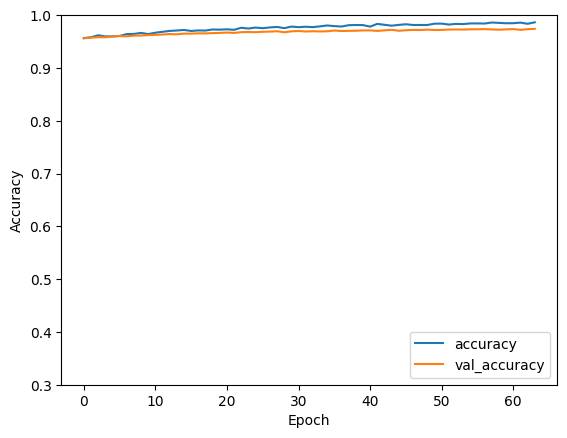

In [25]:
accuracy = history1.history['accuracy'] + history2.history['accuracy']
val_accuracy = history1.history['val_accuracy'] + history2.history['val_accuracy']

plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

We can see that, using the tuned discriminator model, both training accuracy and testing are approximately 0.94 after 15 epochs.

actual label: 4


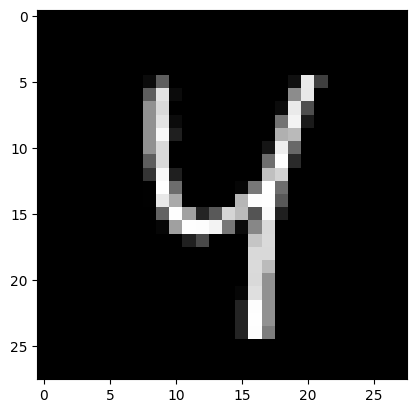

1/1 [==============================] - 0s 49ms/step
[[7.8558891e-08 2.3974803e-06 1.0122899e-07 1.3120263e-06 9.9984670e-01
  3.0063864e-06 4.5264069e-06 1.8829565e-05 5.0035422e-05 7.3070296e-05]]
prediction: 4


2024-11-25 19:45:17.511686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


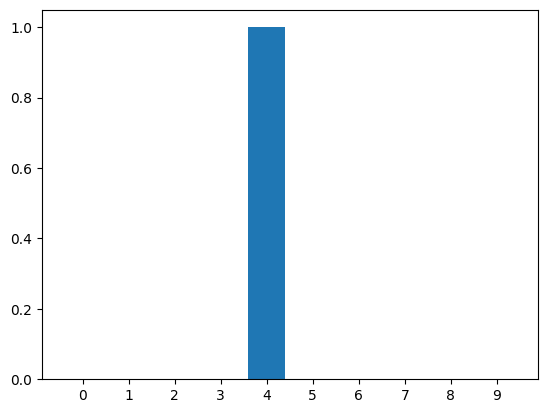

In [26]:
# demonstration: predict the ith test digit
i = np.random.randint(0, trainsize)

# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

# predict
prediction = new_model.predict(test_images[i].reshape(1,28,28,1))

# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), prediction[0,:])
plt.show()

**Get Confusion Matrix**

In [27]:
pred_labels = new_model.predict(test_images).argmax(axis=1)
true_labels = test_labels.argmax(axis=1)

313/313 [==============================] - 2s 6ms/step


In [28]:
confusion_mat = tf.math.confusion_matrix(labels=true_labels, predictions=pred_labels).numpy()
confusion_mat

array([[ 972,    0,    1,    0,    0,    0,    3,    1,    3,    0],
       [   0, 1120,    3,    1,    0,    1,    4,    1,    5,    0],
       [   5,    4,  992,    5,    4,    0,    4,    7,   11,    0],
       [   2,    0,    0,  992,    1,    5,    0,    5,    3,    2],
       [   1,    1,    3,    1,  956,    0,    8,    1,    2,    9],
       [   2,    0,    0,    6,    0,  874,    4,    1,    4,    1],
       [   7,    3,    1,    0,    1,    7,  937,    0,    2,    0],
       [   2,    2,   14,    5,    0,    0,    0,  993,    2,   10],
       [   6,    0,    4,    5,    3,    3,    2,    5,  940,    6],
       [   6,    5,    0,    9,    7,    6,    0,    7,    5,  964]],
      dtype=int32)

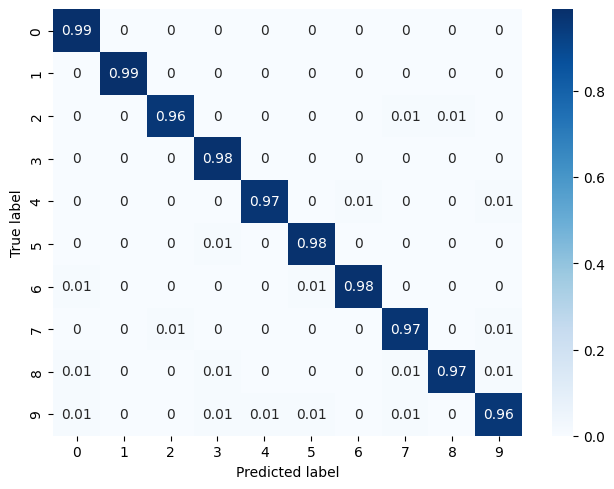

In [29]:
import pandas as pd
import seaborn as sns

confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)

classes = np.arange(0,10).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes, 
                                columns = classes)

figure = plt.figure()
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Generate new digits and perform classification on them using our model**

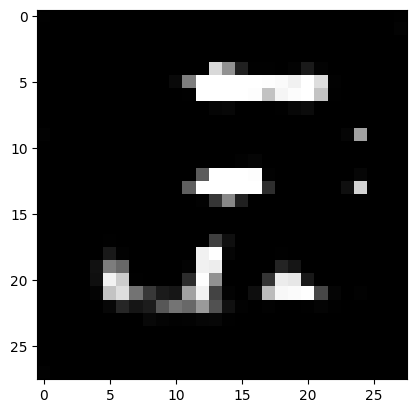

In [30]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
fig = plt.figure()
plt.imshow(sample[0, :, :, 0], cmap='gray')

1/1 [==============================] - 0s 18ms/step
[[4.9854975e-06 1.5582273e-05 3.4023546e-02 1.1600447e-01 8.2774748e-10
  4.3667668e-01 1.0694777e-05 6.1105629e-07 4.1313863e-01 1.2469955e-04]]
prediction: 5


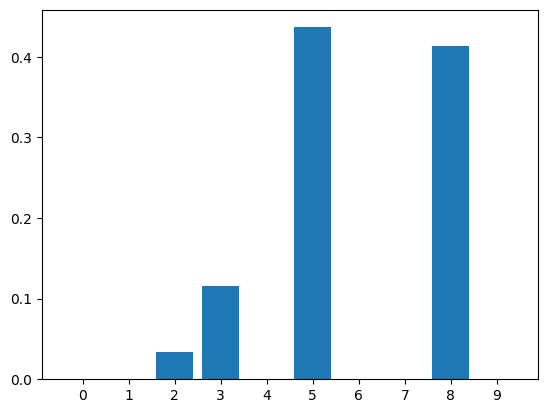

In [31]:
new_sample = sample[0, :, :, 0].numpy().reshape(1,28,28,1)
new_prediction = new_model.predict(new_sample)

# get probability distribution and classification of the test digit
print(new_prediction)
print('prediction:', np.argmax(new_prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), new_prediction[0,:])
plt.show()

In [32]:
# we can save the numpy array of appropriately generated digits as .npy file,
# which could be used for further training
np.save('generated_numpy.npy', sample[0, :, :, 0].numpy())

In [33]:
# upload the saved numpy array
arr = np.load('generated_numpy.npy')
arr

array([[-0.9870455 , -0.9957387 , -0.9999114 , -0.9995829 , -0.99997365,
        -0.9998596 , -0.9999683 , -0.9993896 , -0.9999469 , -0.99989855,
        -0.9999963 , -0.9999919 , -0.9999998 , -0.9999996 , -1.        ,
        -0.99999994, -1.        , -0.9999998 , -0.99999994, -0.9999949 ,
        -0.9999954 , -0.99993277, -0.99998796, -0.9997511 , -0.99961174,
        -0.99679506, -0.9983578 , -0.9883753 ],
       [-0.9929911 , -0.9987237 , -0.99993706, -0.99991035, -0.99998754,
        -0.9999025 , -0.9999715 , -0.99989516, -0.9999177 , -0.99992245,
        -0.9999997 , -0.9999997 , -1.        , -0.9999999 , -1.        ,
        -1.        , -1.        , -0.99999994, -1.        , -0.9999987 ,
        -0.9999956 , -0.9999482 , -0.99999654, -0.9999173 , -0.9997349 ,
        -0.99752486, -0.9988174 , -0.9691015 ],
       [-0.9996644 , -0.99996585, -0.9999998 , -0.99999857, -1.        ,
        -0.99999994, -1.        , -0.9999993 , -0.99999964, -0.9999998 ,
        -1.        , -1.    